In [1]:
import torch
import pandas as pd
import re
from nlp import Dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer
import numpy as np

In [2]:
# read in our tweet sample
tweets = pd.read_csv('../data/tweets_sample.csv', encoding='ISO-8859-1')
tweets.dropna(inplace=True)
print(tweets.shape)
tweets.head()

(6842, 7)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month
0,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1
1,29700,74652,Liverpool,01-04-2020,Meet Alan Supermarket staff like him are worki...,Positive,1
2,29703,74655,"Oklahoma City, OK",01-04-2020,Shopping online has been the go-to option for ...,Positive,1
3,29704,74656,"Minot, ND",01-04-2020,Marketplace Foods in Minot has had the service...,Neutral,1
4,29707,74659,"Lichfield, England",01-04-2020,News Boss of supermarket says buying limits wi...,Neutral,1


In [3]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')

def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs

    return tweet.strip()

print(tweets['OriginalTweet'].iloc[2])
print()
print(clean_tweet(tweets['OriginalTweet'].iloc[2]))


Shopping online has been the go-to option for many people during the COVID19 pandemic but savings experts say you must watch for third-party sellers.



https://t.co/0al9keYAuf

Shopping online has been the go-to option for many people during the COVID19 pandemic but savings experts say you must watch for third-party sellers.



url


In [4]:
tweets['text'] = tweets['OriginalTweet'].apply(clean_tweet)

tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text
0,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...
1,29700,74652,Liverpool,01-04-2020,Meet Alan Supermarket staff like him are worki...,Positive,1,Meet Alan Supermarket staff like him are worki...
2,29703,74655,"Oklahoma City, OK",01-04-2020,Shopping online has been the go-to option for ...,Positive,1,Shopping online has been the go-to option for ...
3,29704,74656,"Minot, ND",01-04-2020,Marketplace Foods in Minot has had the service...,Neutral,1,Marketplace Foods in Minot has had the service...
4,29707,74659,"Lichfield, England",01-04-2020,News Boss of supermarket says buying limits wi...,Neutral,1,News Boss of supermarket says buying limits wi...


<AxesSubplot:>

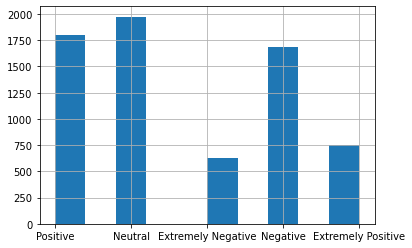

In [5]:
tweets['Sentiment'].hist()

In [6]:
tweets['label'] = tweets['Sentiment'].map({
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Extremely Positive': 2
})

<AxesSubplot:>

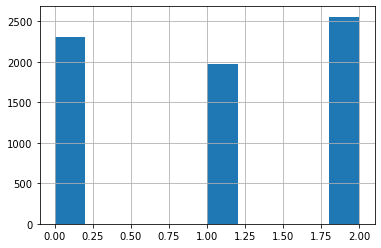

In [7]:
tweets['label'].hist()

In [8]:
tweets.to_csv('../data/cleaned_tweets.csv', index=False)

In [9]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [10]:
tweet_dataset = Dataset.from_pandas(tweets[['text', 'label']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# load our tokenizer

BERT_MODEL = 'distilbert-base-uncased'  # it will lowercase everything and strip accents

bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)

In [12]:
# We will pad our dataset so that our input matrices are the same length and truncate
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [14]:
# set this to see more human readable labels
sequence_classification_model.config.id2label = {
    0: 'NEGATIVE',
    1: 'NEUTRAL',
    2: 'POSITIVE'
}

In [15]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [16]:
len(train_set)

5473

In [17]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer:

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32


{'eval_loss': 1.1058704853057861,
 'eval_accuracy': 0.2870708546384222,
 'eval_runtime': 346.1281,
 'eval_samples_per_second': 3.955,
 'eval_steps_per_second': 0.124}

In [19]:
trainer.train()

/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5473
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 344


Epoch,Training Loss,Validation Loss,Accuracy
1,0.774600,0.536980,0.789627
2,0.377400,0.467769,0.837107


***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32
Saving model checkpoint to ./clf/results/checkpoint-172
Configuration saved in ./clf/results/checkpoint-172/config.json
Model weights saved in ./clf/results/checkpoint-172/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32
Saving model checkpoint to ./clf/results/checkpoint-344
Configuration saved in ./clf/results/checkpoint-344/config.json
Model weights saved in ./clf/results/checkpoint-344/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./clf/results/checkpoint-344 (score: 0.4677692949771881).


TrainOutput(global_step=344, training_loss=0.5760167809419854, metrics={'train_runtime': 7672.8145, 'train_samples_per_second': 1.427, 'train_steps_per_second': 0.045, 'total_flos': 274709684383524.0, 'train_loss': 0.5760167809419854, 'epoch': 2.0})

In [20]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1369
  Batch size = 32


{'eval_loss': 0.4677692949771881,
 'eval_accuracy': 0.8371073776479182,
 'eval_runtime': 346.0742,
 'eval_samples_per_second': 3.956,
 'eval_steps_per_second': 0.124,
 'epoch': 2.0}

In [21]:
trainer.save_model()

Saving model checkpoint to ./clf/results
Configuration saved in ./clf/results/config.json
Model weights saved in ./clf/results/pytorch_model.bin


In [22]:
api_key = 'hf_XXXX'

In [23]:
REPO = 'deploy-mlops-demo'

In [24]:
# need to install  git-lfs. Eg  `brew install git-lfs`

sequence_classification_model.push_to_hub(
    f"profoz/{REPO}",
    use_auth_token=api_key,
    use_temp_dir=True,
)

bert_tokenizer.push_to_hub(
    f"profoz/{REPO}",
    use_auth_token=api_key,
    use_temp_dir=True,
    revision='1'
)


/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:39: FutureWarning: Pass token='deploy-mlops-demo' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  warnings.warn(
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/hf_api.py:673: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/profoz/deploy-mlops-demo into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Configuration saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmpswvogo_x/config.json
Model weights saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmpswvogo_x/pytorch_model.bin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/255M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/profoz/deploy-mlops-demo
   f298f0d..cb163a4  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:39: FutureWarning: Pass token='deploy-mlops-demo' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  warnings.warn(
/Users/sinanozdemir/opt/anaconda3/lib/python3.9/site-packages/huggingface_hub/hf_api.py:673: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning https://huggingface.co/profoz/deploy-mlops-demo into local empty directory.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Download file pytorch_model.bin:   0%|          | 1.53k/255M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

tokenizer config file saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmp71vywt8v/tokenizer_config.json
Special tokens file saved in /var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/tmp71vywt8v/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/profoz/deploy-mlops-demo
   cb163a4..0029ad2  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/profoz/deploy-mlops-demo/commit/0029ad254724bd8ef831f946152df4383e7bc541'

In [39]:
import requests

API_URL = f'https://api-inference.huggingface.co/models/profoz/{REPO}'
headers = {"Authorization": f'Bearer {api_key}'}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

# huggingface API goes to sleep when not in use for a bit
output = query({'inputs': 'covid sucks so bad'})
output

{'error': 'Model profoz/deploy-mlops-demo is currently loading',
 'estimated_time': 20.0}

In [36]:
# a few seconds later..
output = query({'inputs': 'covid sucks so bad'})
output

[[{'label': 'NEGATIVE', 'score': 0.9513265490531921},
  {'label': 'POSITIVE', 'score': 0.025570442900061607},
  {'label': 'NEUTRAL', 'score': 0.023103006184101105}]]